## Preparation

In [1]:
import pandas as pd

* **`parse_dates=[0]`**: We use this parameter to convert the data in the first column (index 0) into the proper `datetime` format.
* **`index_col=0`**: We set this parameter to make the date column our main index, which provides an easier way to slice and filter the dataset by time.

In [2]:
df = pd.read_csv('taxi_2024.csv', index_col = 0, parse_dates = [0])

In [3]:
df.head()

,num_orders
datetime,
2024-03-01 00:00:00,9
2024-03-01 00:10:00,14
2024-03-01 00:20:00,28
2024-03-01 00:30:00,20
2024-03-01 00:40:00,32


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2024-03-01 00:00:00 to 2024-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
print(df.index.is_monotonic_increasing)

True


In [6]:
df.sort_index(inplace=True)

In [7]:
df.head()

,num_orders
datetime,
2024-03-01 00:00:00,9
2024-03-01 00:10:00,14
2024-03-01 00:20:00,28
2024-03-01 00:30:00,20
2024-03-01 00:40:00,32


In [8]:
#df = df['2024-04':'2024-05']
#df.plot()

## Analysis

Since our raw dataset contains high-frequency records (logged every 10 minutes). It is reasonable to aggregate the data into larger intervals to observe clear trends.

Taxi orders are highly dependent on the time of day and rush hours. Therefore, resampling the data by 1 hour (`1H`) and running a parallel experiment with 30-minute intervals (`30min`) is the most optimal approach.

In [9]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

<Axes: xlabel='datetime'>

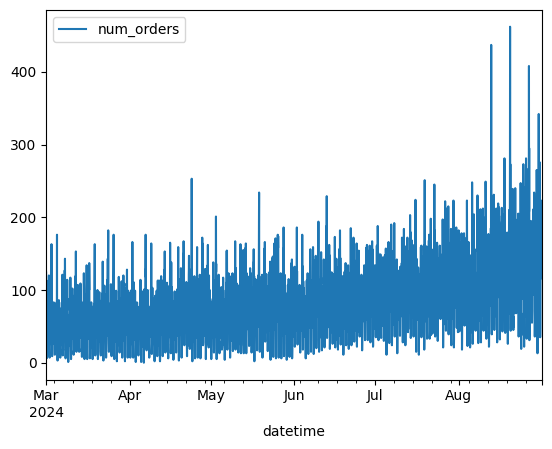

In [10]:
df_1h = df.resample('1h').sum()
df_1h.plot(ax=plt.gca())

<Axes: xlabel='datetime'>

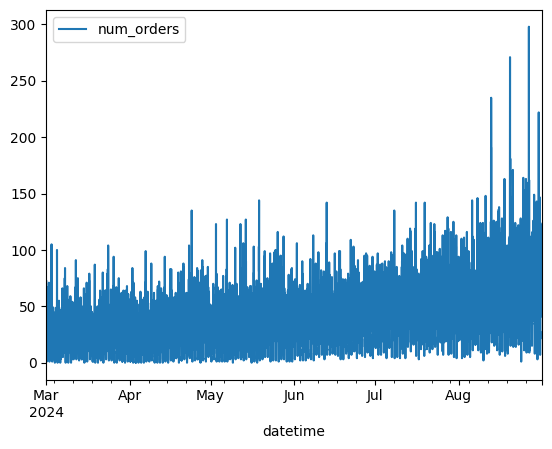

In [11]:
df_30minutes = df.resample('30min').sum()
df_30minutes.plot(ax=plt.gca())

In [12]:
decomposed_1h = seasonal_decompose(df_1h['num_orders'], period = 24)

<Axes: xlabel='datetime'>

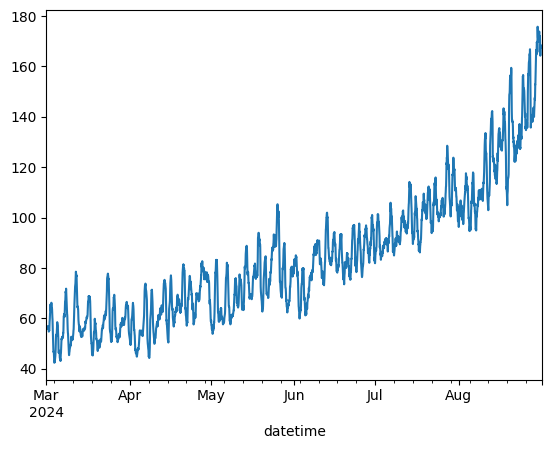

In [13]:
decomposed_1h.trend.plot(ax=plt.gca())

<Axes: xlabel='datetime'>

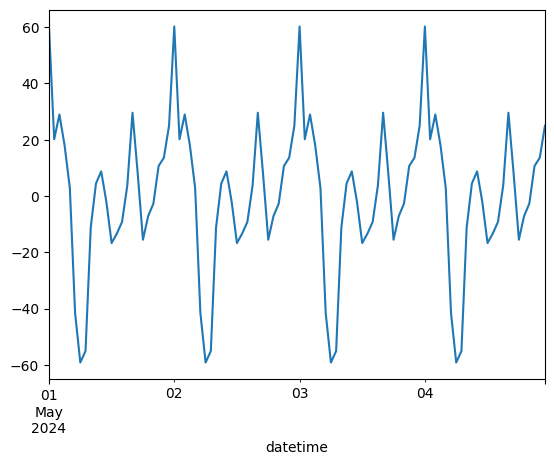

In [14]:
decomposed_1h.seasonal['2024-05-01':'2024-05-04'].plot(ax=plt.gca())

In [15]:
decomposed_30min = seasonal_decompose(df_30minutes['num_orders'], period = 48)

<Axes: xlabel='datetime'>

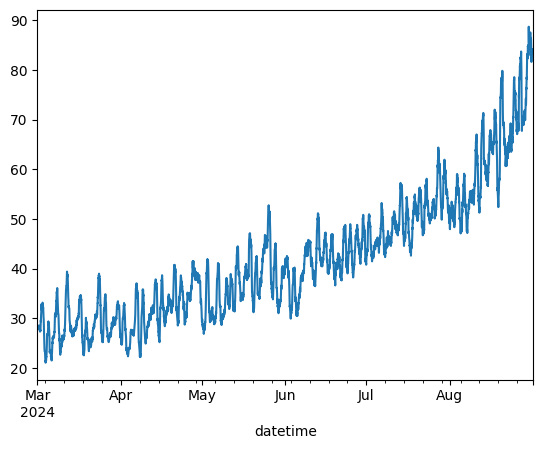

In [16]:
decomposed_30min.trend.plot(ax=plt.gca())

<Axes: xlabel='datetime'>

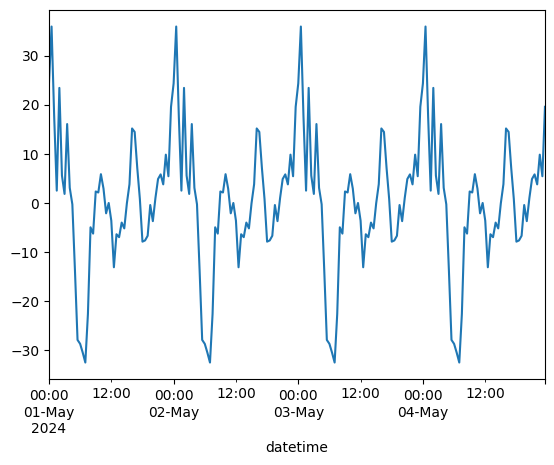

In [17]:
decomposed_30min.seasonal['2024-05-01':'2024-05-04'].plot(ax=plt.gca())

In [18]:
def make_features(data, max_lag, rolling_mean_size):
    df_temp = data.copy()
    df_temp['dayofweek'] = df_temp.index.dayofweek
    df_temp['hour'] = df_temp.index.hour
    data['is_weekend'] = data.index.dayofweek.isin([5, 6]).astype(int)

    for lag in range(1, max_lag + 1):
        df_temp[f'lag_{lag}'] = df_temp['num_orders'].shift(lag)

    df_temp['rolling_mean'] = df_temp['num_orders'].shift(1).rolling(rolling_mean_size).mean()

    return df_temp
df_featured = make_features(df_1h, max_lag=24, rolling_mean_size=24)

df_featured = df_featured.dropna()

print(df_featured.head())

                     num_orders  dayofweek  hour  lag_1  lag_2  lag_3  lag_4  \
datetime                                                                       
2024-03-02 00:00:00          90          5     0   58.0  113.0   66.0   61.0   
2024-03-02 01:00:00         120          5     1   90.0   58.0  113.0   66.0   
2024-03-02 02:00:00          75          5     2  120.0   90.0   58.0  113.0   
2024-03-02 03:00:00          64          5     3   75.0  120.0   90.0   58.0   
2024-03-02 04:00:00          20          5     4   64.0   75.0  120.0   90.0   

                     lag_5  lag_6  lag_7  ...  lag_16  lag_17  lag_18  lag_19  \
datetime                                  ...                                   
2024-03-02 00:00:00   45.0   73.0   44.0  ...    34.0    15.0    12.0     6.0   
2024-03-02 01:00:00   61.0   45.0   73.0  ...    69.0    34.0    15.0    12.0   
2024-03-02 02:00:00   66.0   61.0   45.0  ...    64.0    69.0    34.0    15.0   
2024-03-02 03:00:00  113.0   66.0 

<Axes: xlabel='datetime'>

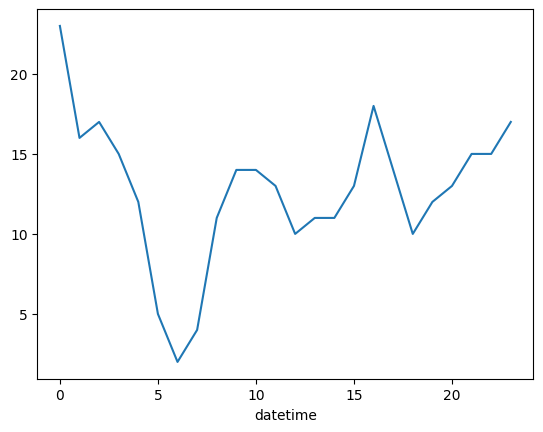

In [19]:
df.groupby(df.index.hour)['num_orders'].median().plot()

## Machine Learning


## Baseline

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

df_featured = df_featured.dropna()

X = df_featured.drop('num_orders', axis=1)
y = df_featured['num_orders']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)

pred_previous = y_test.shift()
pred_previous.iloc[0] = y_train.iloc[-1]

#RMSE
rmse_baseline = mean_squared_error(y_test, pred_previous) ** 0.5

print(f"RMSE of Baseline is: {rmse_baseline:.2f}")

RMSE of Baseline is: 58.88


### Baseline Model Evaluation

The baseline model (predicting the demand based on the previous hour's value) yielded an **RMSE of 58**.

**Business Impact:** An error of 58 orders per hour is critical. From a business perspective, this translates to either a severe shortage of cars (resulting in lost revenue and angry customers) or an excess of idle drivers (wasted salary and fuel). In the long run, this "dumb" forecast can bring to loosing in profits.

**Team Goal:** We are setting a strict internal target of **RMSE < 40** for all advanced Machine Learning models to maximize the financial efficiency of the taxi fleet.

## Testing
